Once deleted, variables cannot be recovered. Proceed (y/[n])? y
Connected!!!
Number of Trades per Minute:  13


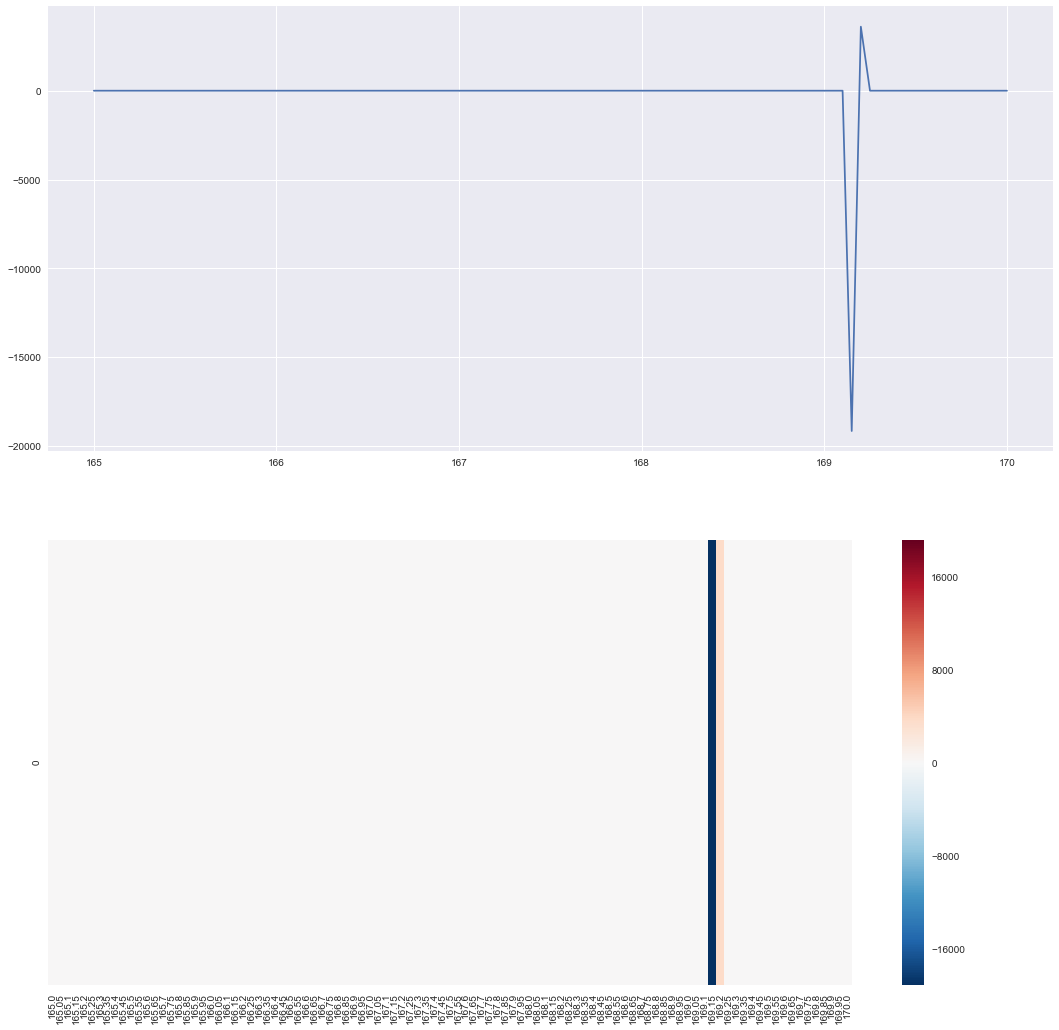

Connected!!!
Number of Trades per Minute:  37


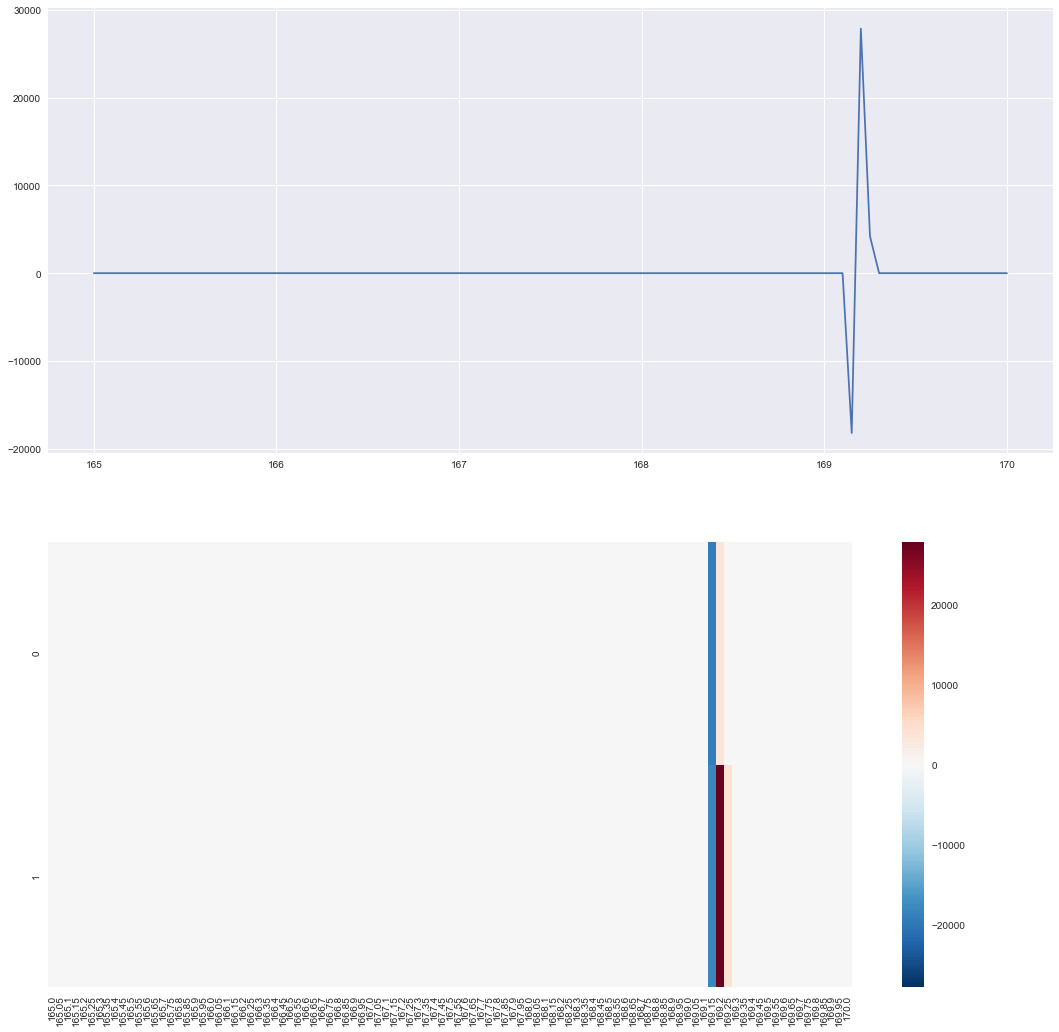

Connected!!!


In [2]:
%reset

from bitmex_websocket import BitMEXWebsocket
from time import sleep
import datetime
import pandas as pd
import time
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
import seaborn as sns

# Counts the total number of trades at each price interval. Counts a buy as positive and sell as negative
def recount(price_list, dataframe):
    
    output_list = []
    
    for each in price_list:
        
        total_size = 0
        i = 0
        
        while i != len(dataframe): 
            if dataframe["Price"][i] == each:
                if dataframe["Order Type"][i] == "Buy": total_size += dataframe["Amount"][i]
                else: total_size -= dataframe["Amount"][i]
            i += 1

        output_list.append(total_size)
        
    return output_list

# Deletes any repeat data that might have already been accounted for in the previous loop.
def remove_previous_data(main_list, delete_list, string):
    
    return_dataframe = main_list
    z = 0
    item_list = []
    
    while z != len(main_list):
        
        m = 0
        
        while m != len(delete_list):
            if main_list[string][z] == delete_list[string][m]:
                item_list.append(z)
            m += 1
            
        z += 1
    
    return_dataframe = return_dataframe.drop(item_list)
    
    return return_dataframe.reset_index(drop = True)

# Price range to record data for.
def price_to_record(lowest_price, highest_price, smallest_price_interval):
    
    number_of_prices = int(((highest_price - lowest_price)/smallest_price_interval) + 1)
    
    prices = np.linspace(lowest_price, highest_price, number_of_prices)
    
    return prices

# Plotting of graphs: Line trade graph and Heatmap. Note that Line graph follows from most recent latest
# trade pull from the BitMEX API
def plot_graphs(historical_list, price_list, trade_counts, number_of_graphs_per_hour):
    
    historical_list.append([price_list, trade_counts])

    r = len(historical_list) % (60/number_of_graphs_per_hour)

    if r == 0:
        plt.figure(figsize=(18,18))
        plt.subplot(211)
        plt.plot(price_list, trade_counts)
        
        heatmap_list = []

        plt.subplot(212)
        for i in range(len(historical_list)):
            heatmap_list.append(historical_list[i][1])

        heatmap_array = np.array(heatmap_list)

        sns.heatmap(heatmap_array, xticklabels = price_list)
        plt.show()
    
    return historical_list, heatmap_array

# Main running loop
def run(data_intervals, number_of_intervals, api_key, api_secret, 
        symbol, lowest_price_to_record, highest_price_to_record, smallest_price_interval, number_of_graphs_per_hour):

    ws = BitMEXWebsocket(endpoint="wss://www.bitmex.com/realtime", 
                         symbol= symbol, 
                         api_key = api_key, 
                         api_secret = api_secret)

    historical_list = []
    delete_list = []
    y = 0

    while(ws.ws.sock.connected):

        print("Connected!!!")
        if y == number_of_intervals:
            break

        sleep(data_intervals)
        if len(ws.recent_trades()) == 0: continue

        item_length = len(ws.recent_trades())
        main_df = pd.DataFrame(columns= ["TransID", "Order Type", "Price", "Amount"])
        i = 0

        while i != item_length:
            main_df = main_df.append({"TransID": str(ws.recent_trades()[i]["trdMatchID"]),
                                      "Order Type": str(ws.recent_trades()[i]["side"]),
                                      "Price": float(ws.recent_trades()[i]["price"]),
                                      "Amount": int(ws.recent_trades()[i]["size"])}, ignore_index = True)
            i += 1

        loaded_df = remove_previous_data(main_df, delete_list, "TransID")
        print("Number of Trades per Minute: ", len(loaded_df))
        
        price_list = price_to_record(lowest_price_to_record, highest_price_to_record, smallest_price_interval)
        
        trade_counts = recount(price_list, loaded_df)
        
        historical_list, heatmap_array = plot_graphs(historical_list, price_list, trade_counts, number_of_graphs_per_hour) 

        delete_list = main_df

        y += 1
        
    return historical_list, heatmap_array

_, _ = run(60, 2, str(api_key_here), str(api_secret_here), "ETHUSD", 165, 170, 0.05, 60)